# Phishing classification

### Problem statement
As users browse various webpages on the internet, phish webpages attempt to steal users' credentials and often poses a reputational and financial risk.
Identifying potential webpages can protect users from these phishing attacks. The objective of this notebook is to analyse the data provided, build a model to predict the probability of webpage being a phish webpage and derive insights to reduce phishing attacks.

In [1]:
# Importing required libraries
import gc
import os
import random
import shutil
import sys
import time
from argparse import Namespace
from collections import OrderedDict
from pathlib import Path
from tqdm.auto import tqdm

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl
from pytorch_lightning import _logger as log
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TestTubeLogger

from transformers import AdamW, BertConfig, BertTokenizer, BertModel, BertPreTrainedModel, get_linear_schedule_with_warmup

from sklearn import model_selection, metrics

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
INPUT_PATH = Path("data")

In [3]:
train = pd.read_csv(INPUT_PATH/"train.csv"); print(f"Train shape: {train.shape}")
test = pd.read_csv(INPUT_PATH/"test.csv"); print(f"Test shape: {test.shape}")

Train shape: (75000, 4)
Test shape: (10000, 3)


In [4]:
train.head()

,Request_Url,Page_Title,FromPageUrl,Label
0,https://binanceoption.cash/?a=signup,binanceoption.cash,https://binanceoption.cash/?ref=Tracy45,1
1,chrome-native://newtab/,Nowa karta,https://www.bing.com/search?q=nowa+rezydencja+...,0
2,https://gmail.com/,NaN,NaN,1
3,http://avzz22.com/dolan/index10_15.html,在线亚洲 第15页-www.avzz13.com-豆豆色avzz13,NaN,0
4,https://homoviper.com/?s=3007706&p=0&tb=3ARB44...,https:\/\/homoviper.com\/?s=3007706&p=0&tb=3AR...,https://homoviper.com/?s=6303648&p=0&tb=3ARB44...,1


In [5]:
test.head()

,Request_Url,Page_Title,FromPageUrl
0,http://campusvirtual.cobamich.edu.mx/,Campus Virtual COBAEM,NaN
1,http://campusvirtual.cobamich.edu.mx/,campusvirtual.cobamich.edu.mx,NaN
2,http://campusvirtual.cobamich.edu.mx/course/vi...,Curso: Metodología de la Investigación#TAB# Mo...,NaN
3,http://campusvirtual.cobamich.edu.mx/course/vi...,campusvirtual.cobamich.edu.mx,NaN
4,http://conditionstray.com/e5wk9k3md8?key=0f22c...,conditionstray.com\/e5wk9k3md8?key=0f22c1fd609...,NaN


### Data Dictionary

- Request_Url – The Url of the Webpage
- Page_Title – The title of the Webpage
- FromPageUrl – The Url of the webpage from where Request_Url webpage was loaded/called from.
- Label – A binary indicator variable where 1 indicates the Request_Url is a Phishing webpage and 0 indicates a non-Phishing webpage.

Text(0, 0.5, 'Count')

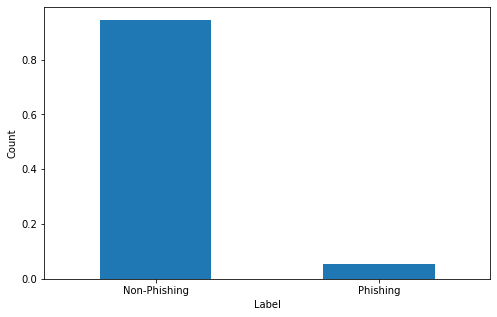

In [6]:
ax = train["Label"].replace({0:"Non-Phishing", 1: "Phishing"}).value_counts(normalize=True).plot(kind='bar', figsize=(8, 5), rot=0)
plt.xlabel("Label")
plt.ylabel("Count")

Target variable (Phishing/non-Phishing) has an imbalance distribution with approximately 6% of positive class.

### Missing values

In [7]:
train.isnull().sum()

Request_Url        0
Page_Title      9957
FromPageUrl    42411
Label              0
dtype: int64

In [8]:
test.isnull().sum()

Request_Url       0
Page_Title     2195
FromPageUrl    4925
dtype: int64

Capturing complex patterns to identify Phish webpages based on request_url and other metadata is a challenging task, especially considering the amount variation involved in the data. In this notebook, BERT is used in order to build a baseline model for predicting the probablity of phish webpage.

### What is BERT?
- Bidirectional Encoder Representations from Transformers (BERT) is a Transformer-based machine learning technique for natural language processing.
- BERT is pretrained on a large corpus of text data on the web in order to learn the language representation.
- Finetuned BERT on custom datasets captures the contextual information to perform wide array of NLP tasks and obtain state-of-the-art results.

### Why BERT?
- Tokenization process involved in BERT can effectively dissect the request url and page title to derive the hidden patterns of Phish webpages.
- BERT allows a seem less way to increase the vocabulary size and learn their representation to improve the model's performance.

### Sentence Pair classification
In this notebook, sentence pair classification approach is employed to build the classification model using Bert base uncased.
Sentence 1: Request_Url  
Sentence 2: Page_Title  
<center><img src='./assets/images/sentence_pair.png' height=400 width=500></center>

### Validation scheme: Stratified KFold Cross Validation (K=5)
<center><img src='./assets/images/cross_validation.png' height=400 width=500></center>

In [9]:
def process_data(
    request_url,
    page_title,
    from_page_url,
    tokenizer,
    max_len
):
    """Preprocess text for transformer model consumption"""
    page_title = " ".join(page_title.strip().split())
    text1 = request_url
    text2 = page_title
    inputs = tokenizer.encode_plus(
        text1,
        text2,
        add_special_tokens=True,
        max_length=max_len,
        padding="max_length",
        return_token_type_ids=True,
        truncation=True
    )
    ids = inputs["input_ids"]
    mask = inputs["attention_mask"]
    token_type_ids = inputs["token_type_ids"]
    
    return { 
        "ids": ids, 
        "mask": mask, 
        "token_type_ids": token_type_ids
    }


class PhishingDataset(torch.utils.data.Dataset):
    """Torch dataset for Phishing classification"""
    def __init__(self, data, tokenizer, max_len, training=True):
        self.request_url = data["Request_Url"].values
        self.page_title = data["Page_Title"].values
        self.from_page_url = data["FromPageUrl"].values
        self.tokenizer = tokenizer
        self.max_len = max_len

        self.training = training
        if training:
            self.label = data["Label"].values

    def __len__(self):
        return len(self.request_url)

    def __getitem__(self, idx):
        inputs = process_data(
                    self.request_url[idx],
                    self.page_title[idx],
                    self.from_page_url[idx],
                    self.tokenizer,
                    self.max_len
                )
        
        inputs["ids"] = torch.tensor(inputs["ids"], dtype=torch.long)
        inputs["mask"] = torch.tensor(inputs["mask"], dtype=torch.long)
        inputs["token_type_ids"] = torch.tensor(inputs["token_type_ids"], dtype=torch.long)
        
        if self.training:
            inputs["target"] = torch.tensor(self.label[idx], dtype=torch.float)

        return inputs
    

class PhishingLitDataModule(pl.LightningDataModule):
    def __init__(self, hparams, train, val, test, tokenizer, max_len):
        super().__init__()
        self.hparams = hparams
        self.train = train
        self.val = val
        self.test = test
        self.tokenizer = tokenizer
        self.max_len = max_len

    def prepare_data(self):
        pass

    def setup(self, stage=None):
        self.train_dataset = PhishingDataset(self.train, self.tokenizer, self.max_len)
        self.val_dataset = PhishingDataset(self.val, self.tokenizer, self.max_len)
        self.test_dataset = PhishingDataset(
            self.test, self.tokenizer, self.max_len, training=False
        )

    def train_dataloader(self):
        dataloader = DataLoader(
            self.train_dataset,
            batch_size=self.hparams.train_batch_size,
            num_workers=self.hparams.num_workers,
            shuffle=True,
            drop_last=False,
            pin_memory=True,
        )
        return dataloader

    def val_dataloader(self):
        dataloader = DataLoader(
            self.val_dataset,
            batch_size=self.hparams.test_batch_size,
            num_workers=self.hparams.num_workers,
            shuffle=False,
            drop_last=False,
            pin_memory=True,
        )
        return dataloader

    def test_dataloader(self):
        dataloader = DataLoader(
            self.test_dataset,
            batch_size=self.hparams.test_batch_size,
            num_workers=self.hparams.num_workers,
            shuffle=False,
            drop_last=False,
            pin_memory=True,
        )
        return dataloader


In [10]:
class PhishingModel(BertPreTrainedModel): 
    """Torch model for Phishing classification""" 
    def __init__(self, pretrained_model_path, config): 
        super(PhishingModel, self).__init__(config) 
        self.bert = BertModel.from_pretrained(pretrained_model_path, config=config)
        self.drop_out = nn.Dropout(0.2) 
        self.linear = nn.Linear(768, 1) 
        torch.nn.init.normal_(self.linear.weight, std=0.02)
    
    def forward(self, ids, mask, token_type_ids): 
        _, _, out = self.bert( input_ids=ids, attention_mask=mask, token_type_ids=token_type_ids ) 
        out = out[-1][:, 0]
        out = self.drop_out(out) 
        logits = self.linear(out) 
        return logits.squeeze()


class PhishingLitModel(pl.LightningModule):
    def __init__(self, hparams, pretrained_model_path, config):
        super().__init__()
        self.hparams = hparams
        self.model = PhishingModel(
            pretrained_model_path=pretrained_model_path,
            config=config,
        )
        self.loss_func = torch.nn.BCEWithLogitsLoss()
        self.save_hyperparameters(hparams)

    def forward(self, x):
        return self.model(x["ids"], x["mask"], x["token_type_ids"])

    def training_step(self, batch, batch_idx):
        batch_logits = self.forward(batch)
        loss = self.loss_func(batch_logits, batch["target"])
        self.log(
            "train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True
        )
        return loss

    def validation_step(self, batch, batch_idx):
        batch_logits = self.forward(batch)
        loss = self.loss_func(batch_logits, batch["target"])
        self.log(
            "val_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True
        )

    def configure_optimizers(self):
        num_train_steps = int(
            self.hparams.train_size
            / self.hparams.train_batch_size
            * self.hparams.nb_epochs
        )
        param_optimizer = list(self.model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {
                "params": [
                    p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
                ],
                "weight_decay": self.hparams.decay,
            },
            {
                "params": [
                    p for n, p in param_optimizer if any(nd in n for nd in no_decay)
                ],
                "weight_decay": 0.0,
            },
        ]
        optimizer = AdamW(optimizer_parameters, lr=self.hparams.learning_rate)
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=self.hparams.num_warm_steps,
            num_training_steps=num_train_steps,
        )
        scheduler = {"scheduler": scheduler, "interval": "step", "frequency": 1}
        return [optimizer], [scheduler]


def predictor(model, data_loader): 
    model = model.cuda() 
    model.eval() 
    predictions = [] 
    with torch.no_grad(): 
        tk0 = tqdm(data_loader, total=len(data_loader)) 
        for _, batch in enumerate(tk0): 
            ids = batch["ids"].cuda() 
            mask = batch["mask"].cuda() 
            token_type_ids = batch["token_type_ids"].cuda() 
            batch_logits = model(ids, mask, token_type_ids) 
            probabilities = torch.sigmoid(batch_logits) 
            predictions.append(probabilities) 
    predictions = torch.cat(predictions, dim=0).detach().cpu().numpy() 
    return predictions


In [11]:
def seed_everything(seed):
    """For reproducibility"""
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [12]:
SUBMISSION_NAME = "phishing"
FOLDS = 5
MAX_LEN = 96
TRAIN_BATCH_SIZE = 128
TEST_BATCH_SIZE = 128
NUM_WORKERS = 8
SEED = 1729

seed_everything(SEED)
hparams = {
    "nb_epochs": 3,
    "train_batch_size": TRAIN_BATCH_SIZE,
    "test_batch_size": TEST_BATCH_SIZE,
    "num_workers": NUM_WORKERS,
    "learning_rate": 0.00002,
    "num_warm_steps": 200,
    "decay": 0.0001
}
hparams = Namespace(**hparams)

PRETRAINED_WEIGHTS_PATH = Path("pretrained_weights/bert-base-uncased/")
run_path = Path(f"{SUBMISSION_NAME}")
logs_path = run_path / "lightning_logs"
model_path = run_path / "model"
predictions_path = run_path / "predictions"
predictions_path.mkdir(exist_ok=True, parents=True)

INPUT_PATH = Path("data")
PRETRAINED_WEIGHTS_PATH = Path("pretrained_weights/bert-base-uncased/")


train = pd.read_csv(INPUT_PATH/"train.csv")
test = pd.read_csv(INPUT_PATH/"test.csv")


train["Page_Title"] = train["Page_Title"].fillna("EMPTY")
train["FromPageUrl"] = train["FromPageUrl"].fillna("EMPTY")


test["Page_Title"] = test["Page_Title"].fillna("EMPTY")
test["FromPageUrl"] = test["FromPageUrl"].fillna("EMPTY")


tokenizer = BertTokenizer.from_pretrained(str(PRETRAINED_WEIGHTS_PATH))
config = BertConfig.from_pretrained(str(PRETRAINED_WEIGHTS_PATH))
config.output_hidden_states = True

skf = model_selection.StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
for fold, (dev_idx, val_idx) in enumerate(skf.split(train, train["Label"])):
    log.info(f"\nRunning fold: {fold}")

    fold_start = time.time()
    fold_logs_path = logs_path / f"fold_{fold}"
    fold_model_path = model_path / f"fold_{fold}"
    if fold_logs_path.exists():
        shutil.rmtree(str(fold_logs_path))
    if fold_model_path.exists():
        shutil.rmtree(str(fold_model_path))

    dev = train.loc[dev_idx, :].reset_index(drop=True)
    val = train.loc[val_idx, :].reset_index(drop=True)

    y_val = train.loc[val_idx, "Label"].values
    print(dev.shape, val.shape, test.shape)

    hparams.train_size = dev.shape[0]

    dm = PhishingLitDataModule(hparams, dev, val, test, tokenizer, MAX_LEN)
    dm.setup()
    model = PhishingLitModel(hparams, PRETRAINED_WEIGHTS_PATH, config)
    testtube_logger = TestTubeLogger(
        str(fold_logs_path), name="PhishingClassification", version=0
    )
    checkpoint_callback = ModelCheckpoint(
        filepath=f"{fold_model_path}/phishingclassification_"
        + "{epoch:02d}-{val_loss_epoch:.4f}",
        save_top_k=1,
        verbose=True,
        monitor="val_loss_epoch",
        mode="min",
    )
    trainer = pl.Trainer(
        weights_summary="top",
        num_sanity_val_steps=0,
        min_epochs=hparams.nb_epochs,
        max_epochs=hparams.nb_epochs,
        checkpoint_callback=checkpoint_callback,
        logger=testtube_logger,
        gpus=1,
        deterministic=True,
        precision=16,
        # fast_dev_run=True
    )
    trainer.fit(model, dm.train_dataloader(), dm.val_dataloader())

    val_probs = predictor(model.model, dm.val_dataloader())
    test_probs = predictor(model.model, dm.test_dataloader())

    fold_loss_score = metrics.log_loss(y_val, val_probs)
    fold_auc_score = metrics.roc_auc_score(y_val, val_probs)

    log.info(f"Val loss: {fold_loss_score:.4f}")
    log.info(f"Val AUC: {fold_auc_score:.4f}")

    val_fold_probs_df = pd.DataFrame({"ClassProbability": val_probs, "Label": y_val})
    val_fold_probs_df.to_csv(
        predictions_path / f"val_preds_{SUBMISSION_NAME}_fold_{fold}.csv", index=False
    )

    test_fold_probs_df = pd.DataFrame({"ClassProbability": test_probs})
    test_fold_probs_df.to_csv(
        predictions_path / f"test_preds_{SUBMISSION_NAME}_fold_{fold}.csv", index=False
    )

    fold_end = time.time()
    message = (
        f"Fold: {fold} runtime: {int((fold_end-fold_start) // 60)}m"
        f" {(fold_end-fold_start) % 60:.0f}s"
    )
    log.info(message)

    del model, dm, trainer
    gc.collect()
    torch.cuda.empty_cache()

In [13]:
threshold = train["Label"].mean()

In [15]:
SUBMISSION_NAME = "phishing"
FOLDS = 5
run_path = Path(f"{SUBMISSION_NAME}")
predictions_path = run_path / "predictions"

In [23]:
val_log_loss_scores = []
val_auc_scores = []
val_f1_scores = []
val_precision_scores = []
val_recall_scores = []
val_probs_df = pd.DataFrame()
final_test_probs = 0
for fold in range(FOLDS):
    val_fold_probs_df = pd.read_csv(predictions_path / f"val_preds_{SUBMISSION_NAME}_fold_{fold}.csv")
    val_fold_probs_df["Prediction"] = np.where(val_fold_probs_df["ClassProbability"] > threshold, 1, 0)
    val_log_loss_scores.append(metrics.log_loss(val_fold_probs_df["Label"], val_fold_probs_df["ClassProbability"]))
    val_auc_scores.append(metrics.roc_auc_score(val_fold_probs_df["Label"], val_fold_probs_df["ClassProbability"]))
    val_f1_scores.append(metrics.f1_score(val_fold_probs_df["Label"], val_fold_probs_df["Prediction"]))
    val_precision_scores.append(metrics.precision_score(val_fold_probs_df["Label"], val_fold_probs_df["Prediction"]))
    val_recall_scores.append(metrics.recall_score(val_fold_probs_df["Label"], val_fold_probs_df["Prediction"]))
    
    val_probs_df = pd.concat([val_probs_df, val_fold_probs_df], sort=False, ignore_index=True)
    
    test_fold_probs_df = pd.read_csv(predictions_path / f"test_preds_{SUBMISSION_NAME}_fold_{fold}.csv")
    final_test_probs += test_fold_probs_df["ClassProbability"]

final_test_probs /= FOLDS

val_log_loss_scores.append(metrics.log_loss(val_probs_df["Label"], val_probs_df["ClassProbability"]))
val_auc_scores.append(metrics.roc_auc_score(val_probs_df["Label"], val_probs_df["ClassProbability"]))
val_f1_scores.append(metrics.f1_score(val_probs_df["Label"], val_probs_df["Prediction"]))
val_precision_scores.append(metrics.precision_score(val_probs_df["Label"], val_probs_df["Prediction"]))
val_recall_scores.append(metrics.recall_score(val_probs_df["Label"], val_probs_df["Prediction"]))

val_names = [f"fold_{i}" for i in range(FOLDS)] + ["full"]

In [24]:
metrics_df = pd.DataFrame({
    "name": val_names,
    "log_loss": val_log_loss_scores,
    "auc": val_auc_scores,
    "f1": val_f1_scores,
    "precision": val_precision_scores,
    "recall": val_recall_scores
})

In [25]:
metrics_df

,name,log_loss,auc,f1,precision,recall
0,fold_0,0.052593,0.984924,0.820312,0.764828,0.884477
1,fold_1,0.066076,0.978939,0.790567,0.740273,0.848193
2,fold_2,0.064348,0.977440,0.788216,0.731682,0.854217
3,fold_3,0.056339,0.981014,0.784607,0.705091,0.884337
4,fold_4,0.061744,0.982399,0.796421,0.743215,0.857831
5,full,0.060220,0.980623,0.795925,0.736475,0.865815


### Observations:
- Metrics are consistent across stratified folds.
- Higher the False Negatives, higher the risk of Phishing attacks for users. Hence, Recall must be improved by fine tuning the threshold and False Positives must be maintained in the acceptable levels at the same time.

### Next steps:
- Modify the tokenizer to incorporate information from FromPageUrl to improve the performance.
- Devise a better thresholding strategy to obtain acceptable levels of recall.
- Build Character-level sequence model to compare the performance.

In [26]:
final_test_predictions = pd.DataFrame({"ClassProbability": final_test_probs})

In [27]:
final_test_predictions.head()

,ClassProbability
0,0.028654
1,0.044322
2,0.002699
3,0.010454
4,0.530927


In [28]:
final_test_predictions.shape

(10000, 1)

In [29]:
final_test_predictions.to_csv("phishingclassification_test_probabilities.csv", index=False)

### References:
- https://arxiv.org/pdf/1810.04805.pdf
- https://scikit-learn.org/stable/modules/cross_validation.html